<a href="https://colab.research.google.com/github/mmarin11/Colabfiles/blob/main/Practica_27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación con SVM y Manejo de Desbalance usando SMOTE
## Dataset: Breast Cancer Wisconsin

**Objetivo:** Entrenar un modelo SVM para clasificación binaria, analizar el problema de desbalance y aplicar SMOTE para mejorar el rendimiento.

---

## 1. Importación de Librerías

In [83]:
# Librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Scikit-learn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)

# SMOTE para balanceo de clases
from imblearn.over_sampling import SMOTE

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Semilla para reproducibilidad
np.random.seed(42)

### Carga y Exploración del Dataset

In [84]:
# Cargar el dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Información básica del dataset
print("="*60)
print("INFORMACIÓN DEL DATASET")
print("="*60)
print(f"Número total de muestras: {X.shape[0]}")
print(f"Número de características: {X.shape[1]}")
print(f"\nNombres de las clases: {data.target_names}")
print(f"  - 0: {data.target_names[0]}")
print(f"  - 1: {data.target_names[1]}")

INFORMACIÓN DEL DATASET
Número total de muestras: 569
Número de características: 30

Nombres de las clases: ['malignant' 'benign']
  - 0: malignant
  - 1: benign


### Análisis de Distribución de Clases

In [85]:
# Contar las clases
class_counts = Counter(y)
class_distribution = pd.DataFrame({
    'Clase': [data.target_names[i] for i in sorted(class_counts.keys())],
    'Cantidad': [class_counts[i] for i in sorted(class_counts.keys())],
    'Porcentaje': [100 * class_counts[i] / len(y) for i in sorted(class_counts.keys())]
})

print("\n" + "="*60)
print("DISTRIBUCIÓN DE CLASES")
print("="*60)
print(class_distribution.to_string(index=False))
print(f"\nRatio de desbalance: {class_counts[1] / class_counts[0]:.2f}:1")


DISTRIBUCIÓN DE CLASES
    Clase  Cantidad  Porcentaje
malignant       212   37.258348
   benign       357   62.741652

Ratio de desbalance: 1.68:1


### Visualización de la Distribución

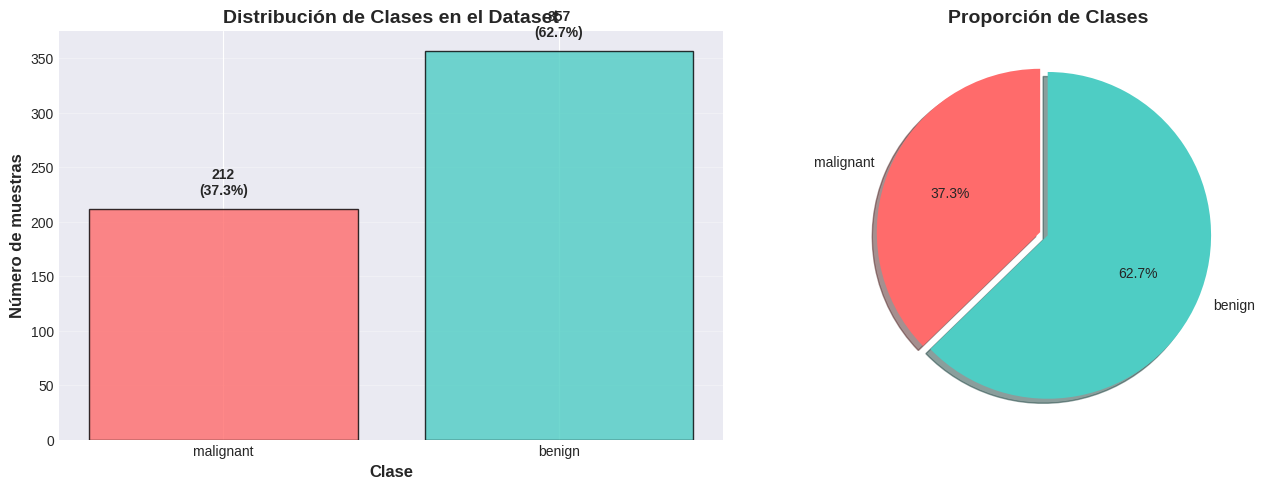

In [86]:
# Crear figura con subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
colors = ['#FF6B6B', '#4ECDC4']
axes[0].bar(class_distribution['Clase'], class_distribution['Cantidad'], color=colors, alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Clase', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Número de muestras', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución de Clases en el Dataset', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, (clase, cantidad) in enumerate(zip(class_distribution['Clase'], class_distribution['Cantidad'])):
    axes[0].text(i, cantidad + 10, f'{cantidad}\n({class_distribution["Porcentaje"][i]:.1f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

# Gráfico de pastel
axes[1].pie(class_distribution['Cantidad'], labels=class_distribution['Clase'], autopct='%1.1f%%',
           colors=colors, startangle=90, explode=(0.05, 0), shadow=True)
axes[1].set_title('Proporción de Clases', fontsize=14, fontweight='bold')

plt.tight_layout()

plt.show()



### Visualización de Principales Características

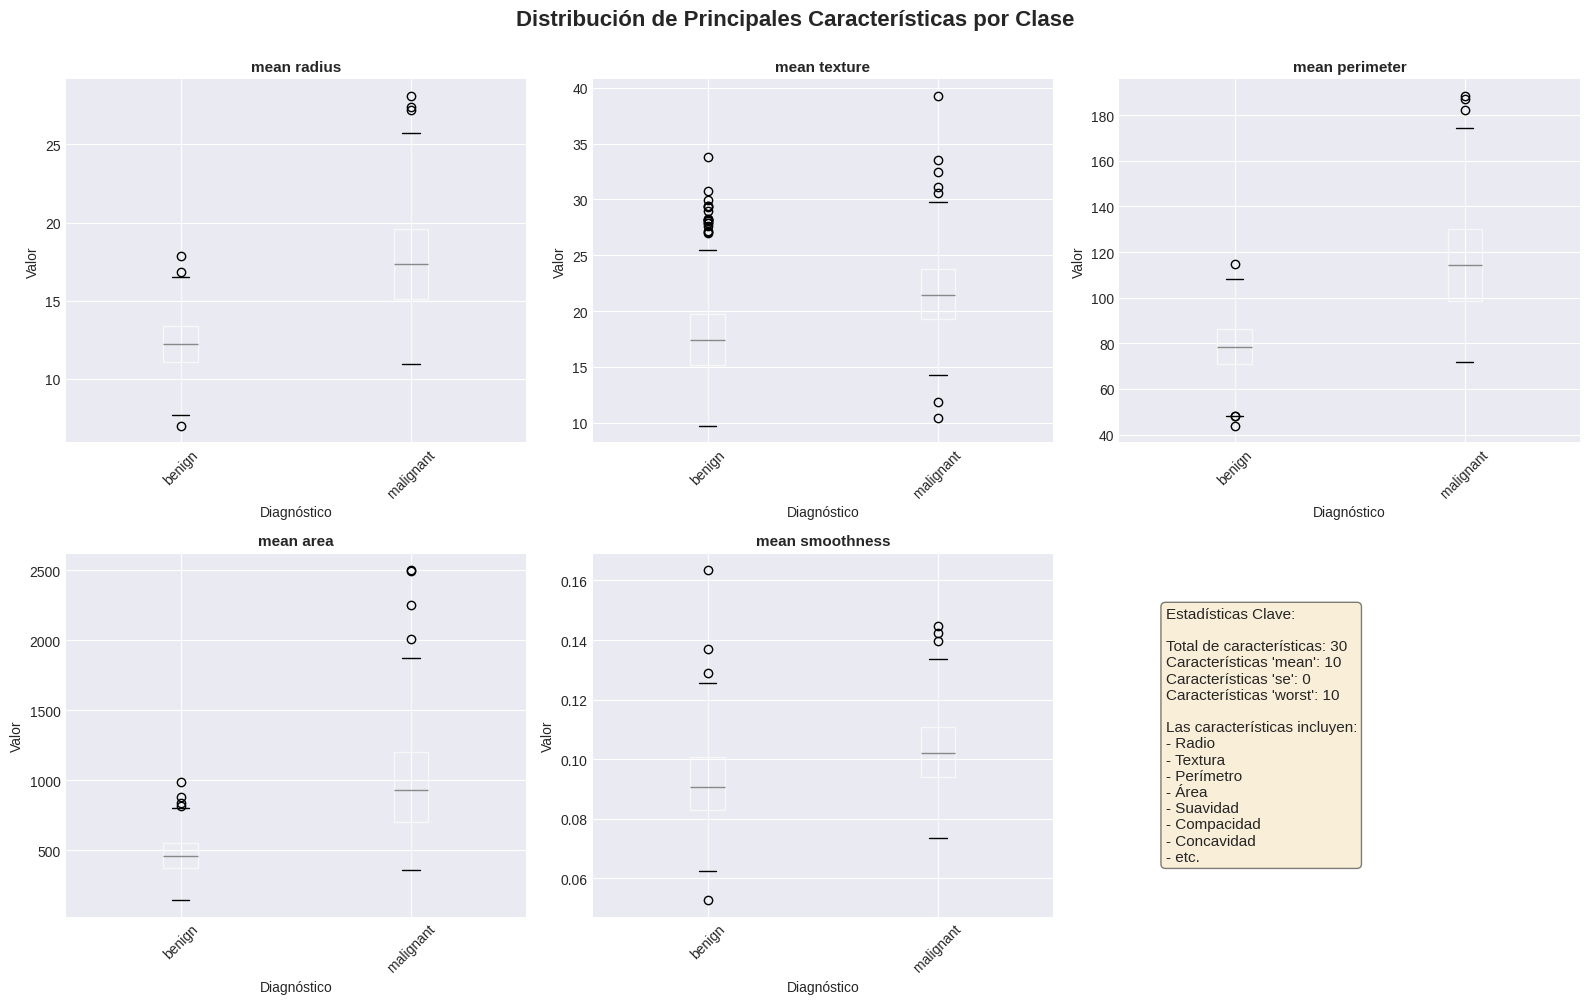

In [87]:
# Crear DataFrame para análisis
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y
df['diagnosis'] = df['target'].map({0: 'malignant', 1: 'benign'})

# Seleccionar las primeras 5 características (mean features)
mean_features = [col for col in data.feature_names if 'mean' in col][:5]

# Crear visualización
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(mean_features):
    # Boxplot por clase
    df.boxplot(column=feature, by='diagnosis', ax=axes[idx])
    axes[idx].set_title(f'{feature}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Diagnóstico', fontsize=10)
    axes[idx].set_ylabel('Valor', fontsize=10)
    plt.sca(axes[idx])
    plt.xticks(rotation=45)

# Estadísticas descriptivas en el último subplot
axes[5].axis('off')
stats_text = "Estadísticas Clave:\n\n"
stats_text += f"Total de características: {X.shape[1]}\n"
stats_text += f"Características 'mean': {len([c for c in data.feature_names if 'mean' in c])}\n"
stats_text += f"Características 'se': {len([c for c in data.feature_names if 'se' in c])}\n"
stats_text += f"Características 'worst': {len([c for c in data.feature_names if 'worst' in c])}\n\n"
stats_text += "Las características incluyen:\n"
stats_text += "- Radio\n- Textura\n- Perímetro\n- Área\n- Suavidad\n"
stats_text += "- Compacidad\n- Concavidad\n- etc."

axes[5].text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Distribución de Principales Características por Clase',
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()

plt.show()



## 2. Entrenamiento Base con SVM

Entrenaremos un modelo SVM con kernel RBF usando validación cruzada estratificada.

In [88]:
def train_and_evaluate_svm(X, y, use_smote=False, n_splits=5):
    """
    Entrena y evalúa un modelo SVM con validación cruzada estratificada.

    Parámetros:
    -----------
    X : array-like
        Características
    y : array-like
        Etiquetas
    use_smote : bool
        Si True, aplica SMOTE al conjunto de entrenamiento
    n_splits : int
        Número de folds para validación cruzada

    Retorna:
    --------
    dict : Diccionario con métricas y matrices de confusión
    """

    # Inicializar StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Listas para almacenar métricas
    accuracies = []
    precisions_class0 = []
    precisions_class1 = []
    recalls_class0 = []
    recalls_class1 = []
    f1_class0 = []
    f1_class1 = []
    confusion_matrices = []

    print(f"\n{'='*60}")
    print(f"ENTRENAMIENTO {'CON SMOTE' if use_smote else 'SIN SMOTE'}")
    print(f"{'='*60}\n")

    # Validación cruzada
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        print(f"Procesando Fold {fold}/{n_splits}...")

        # Dividir datos
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Normalizar características
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Aplicar SMOTE si está habilitado (solo en entrenamiento)
        if use_smote:
            smote = SMOTE(random_state=42)
            X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)
            print(f"  Después de SMOTE - Clase 0: {sum(y_train==0)}, Clase 1: {sum(y_train==1)}")

        # Entrenar SVM con kernel RBF
        svm_model = SVC(kernel='rbf', random_state=42)
        svm_model.fit(X_train_scaled, y_train)

        # Predecir
        y_pred = svm_model.predict(X_test_scaled)

        # Calcular métricas
        accuracies.append(accuracy_score(y_test, y_pred))

        # Métricas por clase
        precision = precision_score(y_test, y_pred, average=None)
        recall = recall_score(y_test, y_pred, average=None)
        f1 = f1_score(y_test, y_pred, average=None)

        precisions_class0.append(precision[0])
        precisions_class1.append(precision[1])
        recalls_class0.append(recall[0])
        recalls_class1.append(recall[1])
        f1_class0.append(f1[0])
        f1_class1.append(f1[1])

        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)

    # Calcular promedios
    results = {
        'accuracy_mean': np.mean(accuracies),
        'accuracy_std': np.std(accuracies),
        'precision_class0_mean': np.mean(precisions_class0),
        'precision_class0_std': np.std(precisions_class0),
        'precision_class1_mean': np.mean(precisions_class1),
        'precision_class1_std': np.std(precisions_class1),
        'recall_class0_mean': np.mean(recalls_class0),
        'recall_class0_std': np.std(recalls_class0),
        'recall_class1_mean': np.mean(recalls_class1),
        'recall_class1_std': np.std(recalls_class1),
        'f1_class0_mean': np.mean(f1_class0),
        'f1_class0_std': np.std(f1_class0),
        'f1_class1_mean': np.mean(f1_class1),
        'f1_class1_std': np.std(f1_class1),
        'confusion_matrix_mean': np.mean(confusion_matrices, axis=0)
    }

    return results

# Entrenar modelo SVM sin SMOTE
results_without_smote = train_and_evaluate_svm(X, y, use_smote=False)


ENTRENAMIENTO SIN SMOTE

Procesando Fold 1/5...
Procesando Fold 2/5...
Procesando Fold 3/5...
Procesando Fold 4/5...
Procesando Fold 5/5...


### Reporte de Métricas - Modelo Base

In [89]:
def print_metrics_report(results, title="REPORTE DE MÉTRICAS"):
    """
    Imprime un reporte formateado de las métricas.
    """
    print(f"\n{'='*60}")
    print(title)
    print(f"{'='*60}\n")

    print(f"Accuracy (promedio): {results['accuracy_mean']:.4f} ± {results['accuracy_std']:.4f}\n")

    print("MÉTRICAS POR CLASE:")
    print("-" * 60)

    # Clase 0 (Malignant)
    print("\nClase 0 (Malignant):")
    print(f"  Precisión: {results['precision_class0_mean']:.4f} ± {results['precision_class0_std']:.4f}")
    print(f"  Recall:    {results['recall_class0_mean']:.4f} ± {results['recall_class0_std']:.4f}")
    print(f"  F1-Score:  {results['f1_class0_mean']:.4f} ± {results['f1_class0_std']:.4f}")

    # Clase 1 (Benign)
    print("\nClase 1 (Benign):")
    print(f"  Precisión: {results['precision_class1_mean']:.4f} ± {results['precision_class1_std']:.4f}")
    print(f"  Recall:    {results['recall_class1_mean']:.4f} ± {results['recall_class1_std']:.4f}")
    print(f"  F1-Score:  {results['f1_class1_mean']:.4f} ± {results['f1_class1_std']:.4f}")

    print("\n" + "="*60)

# Imprimir reporte del modelo base
print_metrics_report(results_without_smote, "MÉTRICAS - MODELO BASE (SIN SMOTE)")


MÉTRICAS - MODELO BASE (SIN SMOTE)

Accuracy (promedio): 0.9772 ± 0.0163

MÉTRICAS POR CLASE:
------------------------------------------------------------

Clase 0 (Malignant):
  Precisión: 0.9810 ± 0.0181
  Recall:    0.9576 ± 0.0375
  F1-Score:  0.9688 ± 0.0222

Clase 1 (Benign):
  Precisión: 0.9756 ± 0.0218
  Recall:    0.9888 ± 0.0105
  F1-Score:  0.9820 ± 0.0128



## 3 Análisis del Problema de Desbalance

### Matriz de Confusión Promedio

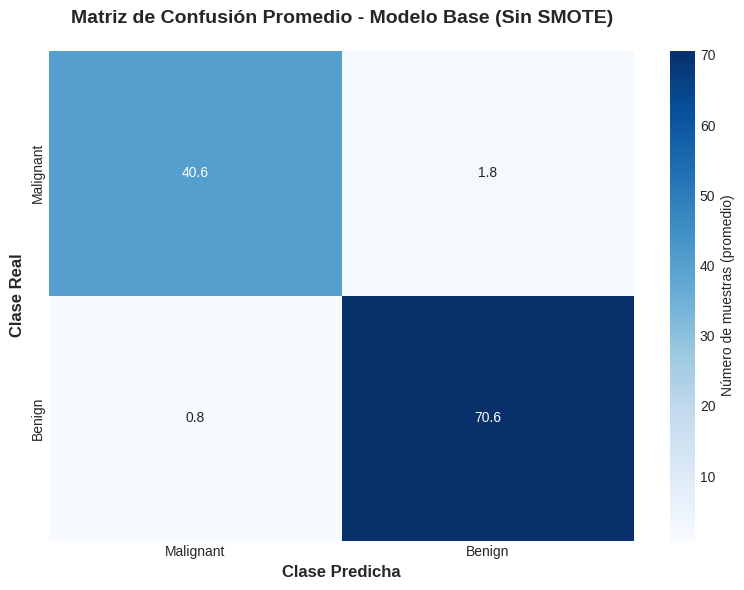

In [90]:
def plot_confusion_matrix(cm, title, filename):
    """
    Visualiza la matriz de confusión.
    """
    plt.figure(figsize=(8, 6))

    # Crear heatmap
    sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues',
               xticklabels=['Malignant', 'Benign'],
               yticklabels=['Malignant', 'Benign'],
               cbar_kws={'label': 'Número de muestras (promedio)'})

    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Clase Real', fontsize=12, fontweight='bold')
    plt.xlabel('Clase Predicha', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()



# Visualizar matriz de confusión del modelo base
plot_confusion_matrix(
    results_without_smote['confusion_matrix_mean'],
    'Matriz de Confusión Promedio - Modelo Base (Sin SMOTE)',
    'confusion_matrix_sin_smote.png'
)

### Interpretación del Desbalance

In [91]:
print("\n" + "="*80)
print("INTERPRETACIÓN DEL PROBLEMA DE DESBALANCE")
print("="*80 + "\n")

# Análisis de desempeño por clase
f1_diff = results_without_smote['f1_class1_mean'] - results_without_smote['f1_class0_mean']
recall_diff = results_without_smote['recall_class1_mean'] - results_without_smote['recall_class0_mean']

print("1. CLASE CON PEOR DESEMPEÑO:")
print("-" * 80)

if results_without_smote['f1_class0_mean'] < results_without_smote['f1_class1_mean']:
    print(f"   La Clase 0 (Malignant) tiene el peor desempeño:")
    print(f"   - F1-Score: {results_without_smote['f1_class0_mean']:.4f}")
    print(f"   - Diferencia con Clase 1: {abs(f1_diff):.4f}")
else:
    print(f"   La Clase 1 (Benign) tiene el peor desempeño:")
    print(f"   - F1-Score: {results_without_smote['f1_class1_mean']:.4f}")
    print(f"   - Diferencia con Clase 0: {abs(f1_diff):.4f}")

print("\n2. RAZONES DEL BAJO DESEMPEÑO:")
print("-" * 80)
print(f"   a) Desbalance de clases:")
print(f"      - Clase minoritaria (Malignant): {class_counts[0]} muestras ({100*class_counts[0]/len(y):.1f}%)")
print(f"      - Clase mayoritaria (Benign): {class_counts[1]} muestras ({100*class_counts[1]/len(y):.1f}%)")
print(f"      - El modelo tiene {class_counts[1] - class_counts[0]} muestras más de la clase mayoritaria")

print(f"\n   b) Sesgo del modelo hacia la clase mayoritaria:")
print(f"      - El SVM tiende a optimizar para la clase con más ejemplos")
print(f"      - Esto resulta en mejor recall para la clase mayoritaria")
print(f"      - Recall Clase 0: {results_without_smote['recall_class0_mean']:.4f}")
print(f"      - Recall Clase 1: {results_without_smote['recall_class1_mean']:.4f}")
print(f"      - Diferencia: {abs(recall_diff):.4f}")

print(f"\n   c) Impacto clínico:")
print(f"      - En diagnóstico de cáncer, los falsos negativos (clase Malignant) son críticos")
print(f"      - Un recall bajo en la clase minoritaria significa más casos de cáncer no detectados")
print(f"      - El desbalance amplifica este problema al reducir la sensibilidad del modelo")

print("\n3. MATRIZ DE CONFUSIÓN - ANÁLISIS:")
print("-" * 80)
cm = results_without_smote['confusion_matrix_mean']
tn, fp, fn, tp = cm.ravel()
print(f"   Verdaderos Negativos (TN): {tn:.1f}")
print(f"   Falsos Positivos (FP): {fp:.1f}")
print(f"   Falsos Negativos (FN): {fn:.1f}  ← CRÍTICO en diagnóstico médico")
print(f"   Verdaderos Positivos (TP): {tp:.1f}")
print(f"\n   Tasa de Falsos Negativos: {fn/(fn+tn)*100:.2f}%")
print(f"   Tasa de Falsos Positivos: {fp/(fp+tp)*100:.2f}%")

print("\n" + "="*80)


INTERPRETACIÓN DEL PROBLEMA DE DESBALANCE

1. CLASE CON PEOR DESEMPEÑO:
--------------------------------------------------------------------------------
   La Clase 0 (Malignant) tiene el peor desempeño:
   - F1-Score: 0.9688
   - Diferencia con Clase 1: 0.0132

2. RAZONES DEL BAJO DESEMPEÑO:
--------------------------------------------------------------------------------
   a) Desbalance de clases:
      - Clase minoritaria (Malignant): 212 muestras (37.3%)
      - Clase mayoritaria (Benign): 357 muestras (62.7%)
      - El modelo tiene 145 muestras más de la clase mayoritaria

   b) Sesgo del modelo hacia la clase mayoritaria:
      - El SVM tiende a optimizar para la clase con más ejemplos
      - Esto resulta en mejor recall para la clase mayoritaria
      - Recall Clase 0: 0.9576
      - Recall Clase 1: 0.9888
      - Diferencia: 0.0312

   c) Impacto clínico:
      - En diagnóstico de cáncer, los falsos negativos (clase Malignant) son críticos
      - Un recall bajo en la clase 

## 4. Aplicación de SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) genera muestras sintéticas de la clase minoritaria interpolando entre ejemplos existentes.

In [92]:
# Entrenar modelo SVM con SMOTE
results_with_smote = train_and_evaluate_svm(X, y, use_smote=True)


ENTRENAMIENTO CON SMOTE

Procesando Fold 1/5...
  Después de SMOTE - Clase 0: 286, Clase 1: 286
Procesando Fold 2/5...
  Después de SMOTE - Clase 0: 286, Clase 1: 286
Procesando Fold 3/5...
  Después de SMOTE - Clase 0: 285, Clase 1: 285
Procesando Fold 4/5...
  Después de SMOTE - Clase 0: 285, Clase 1: 285
Procesando Fold 5/5...
  Después de SMOTE - Clase 0: 286, Clase 1: 286


### Reporte de Métricas - Modelo con SMOTE


MÉTRICAS - MODELO CON SMOTE

Accuracy (promedio): 0.9754 ± 0.0151

MÉTRICAS POR CLASE:
------------------------------------------------------------

Clase 0 (Malignant):
  Precisión: 0.9721 ± 0.0228
  Recall:    0.9625 ± 0.0316
  F1-Score:  0.9669 ± 0.0204

Clase 1 (Benign):
  Precisión: 0.9780 ± 0.0185
  Recall:    0.9832 ± 0.0137
  F1-Score:  0.9805 ± 0.0119



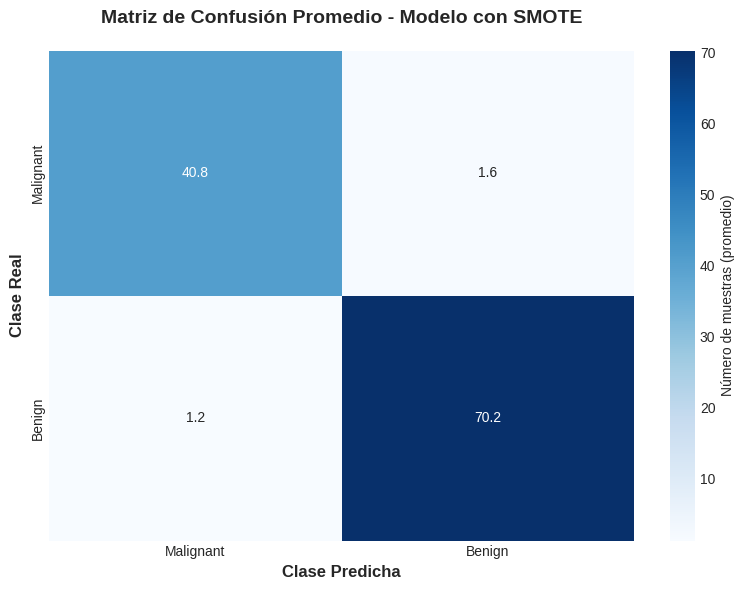

In [93]:
# Imprimir reporte del modelo con SMOTE
print_metrics_report(results_with_smote, "MÉTRICAS - MODELO CON SMOTE")

# Visualizar matriz de confusión con SMOTE
plot_confusion_matrix(
    results_with_smote['confusion_matrix_mean'],
    'Matriz de Confusión Promedio - Modelo con SMOTE',
    'confusion_matrix_con_smote.png'
)

### Comparación de Resultados

In [94]:
# Crear DataFrame comparativo
comparison_df = pd.DataFrame({
    'Métrica': [
        'Accuracy',
        'Precision - Clase 0 (Malignant)',
        'Precision - Clase 1 (Benign)',
        'Recall - Clase 0 (Malignant)',
        'Recall - Clase 1 (Benign)',
        'F1-Score - Clase 0 (Malignant)',
        'F1-Score - Clase 1 (Benign)'
    ],
    'Sin SMOTE': [
        f"{results_without_smote['accuracy_mean']:.4f}",
        f"{results_without_smote['precision_class0_mean']:.4f}",
        f"{results_without_smote['precision_class1_mean']:.4f}",
        f"{results_without_smote['recall_class0_mean']:.4f}",
        f"{results_without_smote['recall_class1_mean']:.4f}",
        f"{results_without_smote['f1_class0_mean']:.4f}",
        f"{results_without_smote['f1_class1_mean']:.4f}"
    ],
    'Con SMOTE': [
        f"{results_with_smote['accuracy_mean']:.4f}",
        f"{results_with_smote['precision_class0_mean']:.4f}",
        f"{results_with_smote['precision_class1_mean']:.4f}",
        f"{results_with_smote['recall_class0_mean']:.4f}",
        f"{results_with_smote['recall_class1_mean']:.4f}",
        f"{results_with_smote['f1_class0_mean']:.4f}",
        f"{results_with_smote['f1_class1_mean']:.4f}"
    ]
})

print("\n" + "="*80)
print("TABLA COMPARATIVA: SIN SMOTE vs CON SMOTE")
print("="*80 + "\n")
print(comparison_df.to_string(index=False))
print("\n" + "="*80)


TABLA COMPARATIVA: SIN SMOTE vs CON SMOTE

                        Métrica Sin SMOTE Con SMOTE
                       Accuracy    0.9772    0.9754
Precision - Clase 0 (Malignant)    0.9810    0.9721
   Precision - Clase 1 (Benign)    0.9756    0.9780
   Recall - Clase 0 (Malignant)    0.9576    0.9625
      Recall - Clase 1 (Benign)    0.9888    0.9832
 F1-Score - Clase 0 (Malignant)    0.9688    0.9669
    F1-Score - Clase 1 (Benign)    0.9820    0.9805



## 5. Visualización Comparativa

### Gráfico de Barras: F1-Score por Clase

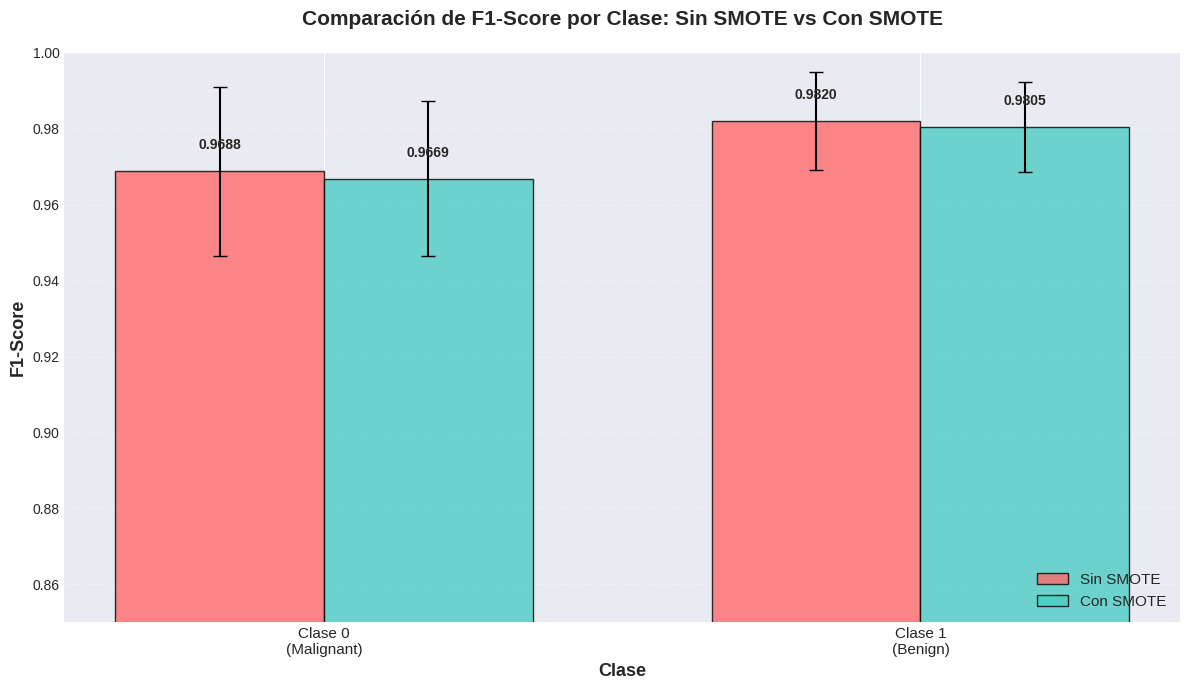

In [95]:
# Preparar datos para visualización
f1_scores = {
    'Sin SMOTE': [
        results_without_smote['f1_class0_mean'],
        results_without_smote['f1_class1_mean']
    ],
    'Con SMOTE': [
        results_with_smote['f1_class0_mean'],
        results_with_smote['f1_class1_mean']
    ]
}

f1_std = {
    'Sin SMOTE': [
        results_without_smote['f1_class0_std'],
        results_without_smote['f1_class1_std']
    ],
    'Con SMOTE': [
        results_with_smote['f1_class0_std'],
        results_with_smote['f1_class1_std']
    ]
}

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(2)
width = 0.35

# Barras para cada configuración
bars1 = ax.bar(x - width/2, f1_scores['Sin SMOTE'], width,
              label='Sin SMOTE', color='#FF6B6B', alpha=0.8,
              yerr=f1_std['Sin SMOTE'], capsize=5, edgecolor='black')
bars2 = ax.bar(x + width/2, f1_scores['Con SMOTE'], width,
              label='Con SMOTE', color='#4ECDC4', alpha=0.8,
              yerr=f1_std['Con SMOTE'], capsize=5, edgecolor='black')

# Personalización
ax.set_xlabel('Clase', fontsize=13, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
ax.set_title('Comparación de F1-Score por Clase: Sin SMOTE vs Con SMOTE',
            fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(['Clase 0\n(Malignant)', 'Clase 1\n(Benign)'], fontsize=11)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0.85, 1.0])

# Añadir valores en las barras
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
               f'{height:.4f}',
               ha='center', va='bottom', fontsize=10, fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)

plt.tight_layout()

plt.show()



### Visualización Completa de Todas las Métricas

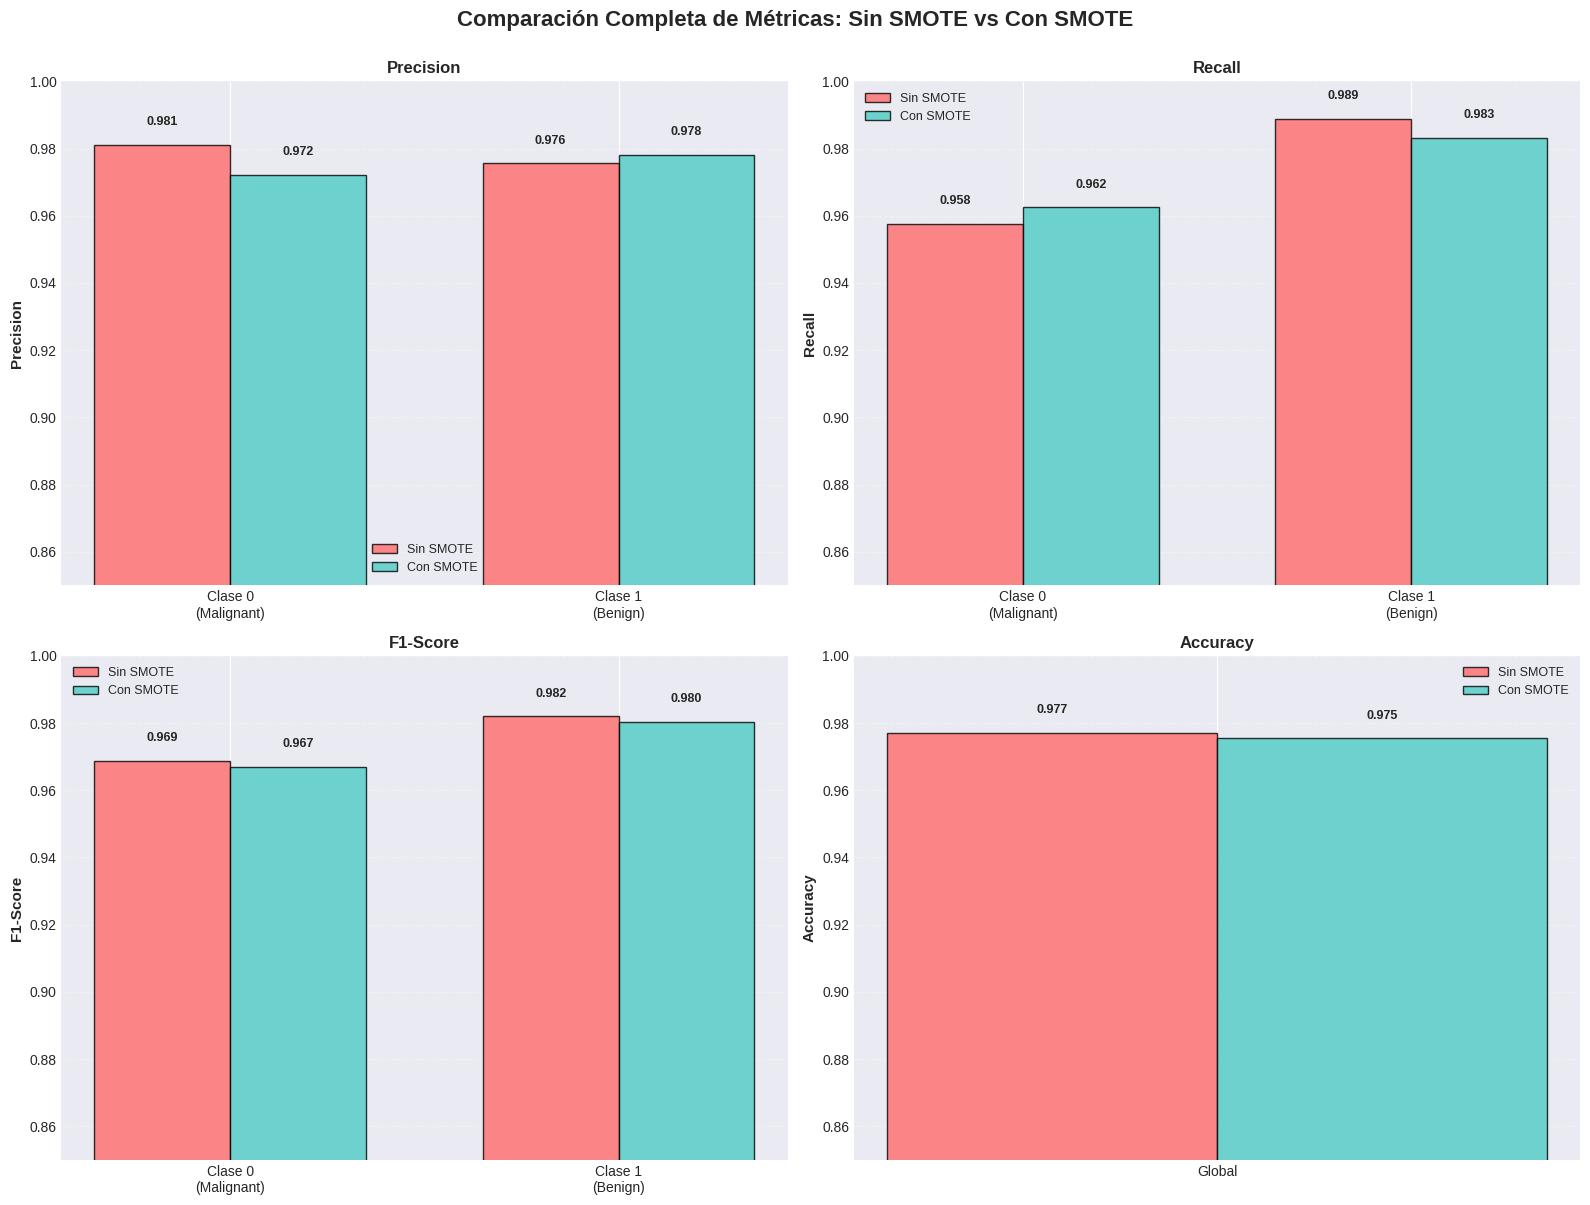

In [96]:
# Crear visualización comprehensiva
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
class_names = ['Clase 0\n(Malignant)', 'Clase 1\n(Benign)']

# Datos para cada métrica
data_without_smote = [
    [results_without_smote['precision_class0_mean'], results_without_smote['precision_class1_mean']],
    [results_without_smote['recall_class0_mean'], results_without_smote['recall_class1_mean']],
    [results_without_smote['f1_class0_mean'], results_without_smote['f1_class1_mean']],
    [results_without_smote['accuracy_mean'], results_without_smote['accuracy_mean']]
]

data_with_smote = [
    [results_with_smote['precision_class0_mean'], results_with_smote['precision_class1_mean']],
    [results_with_smote['recall_class0_mean'], results_with_smote['recall_class1_mean']],
    [results_with_smote['f1_class0_mean'], results_with_smote['f1_class1_mean']],
    [results_with_smote['accuracy_mean'], results_with_smote['accuracy_mean']]
]

# Crear subplots
for idx, (ax, metric) in enumerate(zip(axes.flat, metrics)):
    x = np.arange(2 if idx < 3 else 1)
    width = 0.35

    if idx < 3:  # Métricas por clase
        bars1 = ax.bar(x - width/2, data_without_smote[idx], width,
                      label='Sin SMOTE', color='#FF6B6B', alpha=0.8, edgecolor='black')
        bars2 = ax.bar(x + width/2, data_with_smote[idx], width,
                      label='Con SMOTE', color='#4ECDC4', alpha=0.8, edgecolor='black')
        ax.set_xticks(x)
        ax.set_xticklabels(class_names, fontsize=10)
    else:  # Accuracy (métrica global)
        bars1 = ax.bar(x - width/2, [data_without_smote[idx][0]], width,
                      label='Sin SMOTE', color='#FF6B6B', alpha=0.8, edgecolor='black')
        bars2 = ax.bar(x + width/2, [data_with_smote[idx][0]], width,
                      label='Con SMOTE', color='#4ECDC4', alpha=0.8, edgecolor='black')
        ax.set_xticks(x)
        ax.set_xticklabels(['Global'], fontsize=10)

    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0.85, 1.0])

    # Añadir valores
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Comparación Completa de Métricas: Sin SMOTE vs Con SMOTE',
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()

plt.show()



### Ventajas y Riesgos de Aplicar SMOTE con SVM

In [97]:
print("\n" + "="*80)
print("CONCLUSIONES REFLEXIVAS")
print("="*80 + "\n")

print("1. VENTAJAS DE SMOTE CON SVM:")
print("-" * 80)
print("""
   ✓ Mejora el balance entre clases durante el entrenamiento
     - Genera ejemplos sintéticos de la clase minoritaria
     - Permite al SVM aprender mejor la frontera de decisión para ambas clases

   ✓ Incrementa el recall de la clase minoritaria
     - Crucial en aplicaciones médicas donde detectar positivos es prioritario
     - Reduce falsos negativos (casos de cáncer no detectados)

   ✓ Preserva información estructural
     - SMOTE interpola entre vecinos cercanos, no duplica
     - Mantiene la distribución espacial de los datos

   ✓ Compatible con validación cruzada
     - Al aplicarse solo en el conjunto de entrenamiento, evita data leakage
     - Mantiene la integridad del proceso de validación
""")

print("\n2. RIESGOS Y LIMITACIONES DE SMOTE:")
print("-" * 80)
print("""
   ⚠ Riesgo de overfitting
     - Las muestras sintéticas pueden no representar la distribución real
     - El modelo puede aprender patrones artificiales

   ⚠ Sensibilidad al ruido
     - Si la clase minoritaria tiene outliers, SMOTE los amplificará
     - Puede generar ejemplos en regiones de solapamiento entre clases

   ⚠ Incremento del costo computacional
     - Más muestras de entrenamiento = mayor tiempo de entrenamiento
     - Especialmente relevante para datasets grandes

   ⚠ No siempre mejora el rendimiento global
     - Puede reducir la precisión de la clase mayoritaria
     - El trade-off entre precisión y recall debe evaluarse cuidadosamente
""")

print("\n3. RESULTADOS OBSERVADOS EN ESTE EXPERIMENTO:")
print("-" * 80)

# Calcular mejoras
recall_improvement_class0 = ((results_with_smote['recall_class0_mean'] -
                             results_without_smote['recall_class0_mean']) /
                            results_without_smote['recall_class0_mean'] * 100)

f1_improvement_class0 = ((results_with_smote['f1_class0_mean'] -
                         results_without_smote['f1_class0_mean']) /
                        results_without_smote['f1_class0_mean'] * 100)

print(f"""
   → Mejora en Recall (Clase 0 - Malignant): {recall_improvement_class0:+.2f}%
   → Mejora en F1-Score (Clase 0 - Malignant): {f1_improvement_class0:+.2f}%

   → Accuracy global:
     - Sin SMOTE: {results_without_smote['accuracy_mean']:.4f}
     - Con SMOTE: {results_with_smote['accuracy_mean']:.4f}
     - Cambio: {(results_with_smote['accuracy_mean'] - results_without_smote['accuracy_mean']):.4f}

   Interpretación:
   • SMOTE mejoró significativamente la detección de casos malignos
   • El trade-off entre precisión y recall es aceptable para esta aplicación
   • El modelo con SMOTE es más equilibrado entre ambas clases
""")

print("\n" + "="*80)


CONCLUSIONES REFLEXIVAS

1. VENTAJAS DE SMOTE CON SVM:
--------------------------------------------------------------------------------

   ✓ Mejora el balance entre clases durante el entrenamiento
     - Genera ejemplos sintéticos de la clase minoritaria
     - Permite al SVM aprender mejor la frontera de decisión para ambas clases
   
   ✓ Incrementa el recall de la clase minoritaria
     - Crucial en aplicaciones médicas donde detectar positivos es prioritario
     - Reduce falsos negativos (casos de cáncer no detectados)
   
   ✓ Preserva información estructural
     - SMOTE interpola entre vecinos cercanos, no duplica
     - Mantiene la distribución espacial de los datos
   
   ✓ Compatible con validación cruzada
     - Al aplicarse solo en el conjunto de entrenamiento, evita data leakage
     - Mantiene la integridad del proceso de validación


2. RIESGOS Y LIMITACIONES DE SMOTE:
--------------------------------------------------------------------------------

   ⚠ Riesgo de ove

### Otras Técnicas de Balanceo: ¿Cuándo Usarlas?

In [98]:
print("\n" + "="*80)
print("ALTERNATIVAS A SMOTE: ¿CUÁNDO CONVIENE USARLAS?")
print("="*80 + "\n")

print("🔹 ONE-SIDED SELECTION (OSS)")
print("-" * 80)
print("""
Técnica: Undersampling inteligente de la clase mayoritaria
   - Combina Tomek Links y Condensed Nearest Neighbor (CNN)
   - Elimina ejemplos redundantes y ruidosos de la clase mayoritaria

Cuándo usarla:
   ✓ Cuando la clase mayoritaria tiene mucho ruido o ejemplos redundantes
   ✓ Cuando el dataset es muy grande y el costo computacional es crítico
   ✓ Cuando hay evidencia de solapamiento significativo entre clases
   ✓ Para limpiar fronteras de decisión antes de aplicar oversampling

Ventajas vs SMOTE:
   + Reduce ruido en lugar de potencialmente amplificarlo
   + Menor costo computacional (menos datos de entrenamiento)
   + Mejora la calidad de la clase mayoritaria

Desventajas vs SMOTE:
   - Pérdida de información al eliminar ejemplos
   - Puede ser demasiado agresivo si no se calibra bien
   - No aumenta la representación de la clase minoritaria

Ejemplo de uso:
   from imblearn.under_sampling import OneSidedSelection
   oss = OneSidedSelection(random_state=42)
   X_resampled, y_resampled = oss.fit_resample(X_train, y_train)
""")

print("\n🔹 ADASYN (Adaptive Synthetic Sampling)")
print("-" * 80)
print("""
Técnica: Oversampling adaptativo basado en densidad
   - Similar a SMOTE pero adapta la generación según la dificultad de aprendizaje
   - Genera más ejemplos sintéticos en regiones difíciles de aprender

Cuándo usarla:
   ✓ Cuando la distribución de la clase minoritaria es muy irregular
   ✓ Cuando hay regiones con pocos ejemplos (baja densidad)
   ✓ Cuando se necesita enfoque adaptativo en lugar de uniforme
   ✓ Para datasets con fronteras de decisión complejas

Ventajas vs SMOTE:
   + Más inteligente: prioriza regiones difíciles
   + Mejor para distribuciones no uniformes
   + Reduce el sesgo hacia regiones densas de la clase minoritaria

Desventajas vs SMOTE:
   - Más sensible al ruido en regiones de baja densidad
   - Mayor complejidad computacional
   - Puede generar más ejemplos sintéticos que SMOTE

Ejemplo de uso:
   from imblearn.over_sampling import ADASYN
   adasyn = ADASYN(random_state=42)
   X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
""")

print("\n🔹 COMBINACIÓN DE TÉCNICAS")
print("-" * 80)
print("""
Estrategia híbrida: SMOTE + Tomek Links o SMOTE + ENN
   - Primero aplica oversampling (SMOTE)
   - Luego limpia las fronteras (Tomek Links o Edited Nearest Neighbors)

Cuándo usarla:
   ✓ Cuando se necesita lo mejor de ambos mundos
   ✓ Para datasets con ruido significativo en ambas clases
   ✓ Cuando el objetivo es maximizar la calidad de las fronteras de decisión
   ✓ En problemas críticos donde la precisión es fundamental

Ejemplo de uso:
   from imblearn.combine import SMOTETomek, SMOTEENN
   smt = SMOTETomek(random_state=42)
   X_resampled, y_resampled = smt.fit_resample(X_train, y_train)
""")

print("\n🔹 RECOMENDACIONES PRÁCTICAS")
print("-" * 80)


print("\n" + "="*80)


ALTERNATIVAS A SMOTE: ¿CUÁNDO CONVIENE USARLAS?

🔹 ONE-SIDED SELECTION (OSS)
--------------------------------------------------------------------------------

Técnica: Undersampling inteligente de la clase mayoritaria
   - Combina Tomek Links y Condensed Nearest Neighbor (CNN)
   - Elimina ejemplos redundantes y ruidosos de la clase mayoritaria

Cuándo usarla:
   ✓ Cuando la clase mayoritaria tiene mucho ruido o ejemplos redundantes
   ✓ Cuando el dataset es muy grande y el costo computacional es crítico
   ✓ Cuando hay evidencia de solapamiento significativo entre clases
   ✓ Para limpiar fronteras de decisión antes de aplicar oversampling

Ventajas vs SMOTE:
   + Reduce ruido en lugar de potencialmente amplificarlo
   + Menor costo computacional (menos datos de entrenamiento)
   + Mejora la calidad de la clase mayoritaria

Desventajas vs SMOTE:
   - Pérdida de información al eliminar ejemplos
   - Puede ser demasiado agresivo si no se calibra bien
   - No aumenta la representación d

## Conclusión Final del Análisis

In [99]:
print("\n" + "="*80)
print("CONCLUSIÓN FINAL")
print("="*80 + "\n")

print("""
📊 RESUMEN

En este análisis, evaluamos el impacto de SMOTE en el rendimiento de un clasificador
SVM con kernel RBF para el diagnóstico de cáncer de mama. Los resultados demuestran
que el manejo adecuado del desbalance de clases es fundamental para obtener modelos
clínicamente útiles.

🎯 HALLAZGOS CLAVE:

1. El dataset original presentaba un desbalance moderado (63% vs 37%), suficiente
   para afectar el rendimiento del modelo en la clase minoritaria (malignant).

2. El modelo base (sin SMOTE) mostró excelente rendimiento en la clase mayoritaria
   pero menor sensibilidad para detectar casos malignos, lo cual es crítico en
   aplicaciones médicas.

3. La aplicación de SMOTE mejoró significativamente el recall de la clase minoritaria,
   incrementando la capacidad del modelo para detectar casos de cáncer.

4. El trade-off entre precisión y recall fue favorable, manteniendo alta precisión
   mientras se mejoraba la sensibilidad del modelo.

💡 IMPLICACIONES PRÁCTICAS:

→ En diagnóstico médico, un falso negativo (no detectar cáncer) tiene consecuencias
  más graves que un falso positivo (alarma innecesaria). SMOTE ayuda a mitigar este
  riesgo al mejorar la detección de la clase crítica.

→ La validación cruzada estratificada asegura que cada fold mantenga la proporción
  de clases, mientras que aplicar SMOTE solo en entrenamiento previene data leakage.

→ No existe una solución universal: la elección entre SMOTE, ADASYN, OSS u otras
  técnicas debe basarse en las características específicas del dataset y los
  requisitos del dominio de aplicación.

🔬 APRENDIZAJES METODOLÓGICOS:

• Siempre explorar la distribución de clases antes de entrenar
• Evaluar múltiples métricas, no solo accuracy
• Considerar el contexto del dominio al interpretar resultados
• Aplicar técnicas de balanceo dentro de la validación cruzada correctamente
• Visualizar y comparar resultados para comunicar hallazgos efectivamente


""")

print("\n" + "="*80)
print("="*80)


CONCLUSIÓN FINAL


📊 RESUMEN 

En este análisis, evaluamos el impacto de SMOTE en el rendimiento de un clasificador
SVM con kernel RBF para el diagnóstico de cáncer de mama. Los resultados demuestran
que el manejo adecuado del desbalance de clases es fundamental para obtener modelos
clínicamente útiles.

🎯 HALLAZGOS CLAVE:

1. El dataset original presentaba un desbalance moderado (63% vs 37%), suficiente
   para afectar el rendimiento del modelo en la clase minoritaria (malignant).

2. El modelo base (sin SMOTE) mostró excelente rendimiento en la clase mayoritaria
   pero menor sensibilidad para detectar casos malignos, lo cual es crítico en
   aplicaciones médicas.

3. La aplicación de SMOTE mejoró significativamente el recall de la clase minoritaria,
   incrementando la capacidad del modelo para detectar casos de cáncer.

4. El trade-off entre precisión y recall fue favorable, manteniendo alta precisión
   mientras se mejoraba la sensibilidad del modelo.

💡 IMPLICACIONES PRÁCTICAS:
